In [117]:
import shapely
import pandas as pd
from shapely.geometry import LineString
from shapely.geometry import Point
import osmnx as ox
import geopandas as gpd
from numpy.linalg import norm
import numpy as np
import math
from matplotlib import pyplot as plt
import contextily as cx
from pyproj.crs import CRS
import scipy
from datetime import timedelta
import pyproj

from shapely.ops import linemerge

import route2vel
import route2vel.utils as utils
from route2vel.loading import load_graph
import route2vel
from notebookutils import *

from route2vel.interp import *
from route2vel.route import *
from route2vel.classes import *

In [118]:
from route2vel.postprocess import *

In [119]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [120]:
plt.style.use('dark_background')
route2vel.load_config("..")
ox.settings.use_cache = False

In [121]:
route_steps = ["Zola Predosa", "Castel San Pietro Terme"]

In [122]:
direction = route2vel.find_route_osrm(route_steps, load_graph=True, load_graph_name='test_route_1')

Loading graph from d:\Documenti\Universita\tesim\src\graph\test_route_1.graphnx.pickle ...
Loaded in 0.83s!


In [123]:
print(f"Route length: {len(direction.geometry)} (osm nodes: {len(direction.nodelist())})")

Route length: 28 (osm nodes: 64)


In [127]:
interp_dir = route2vel.interp_from_route(direction)

d:\Documenti\Universita\tesim\.venv\Lib\site-packages\geopandas\plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


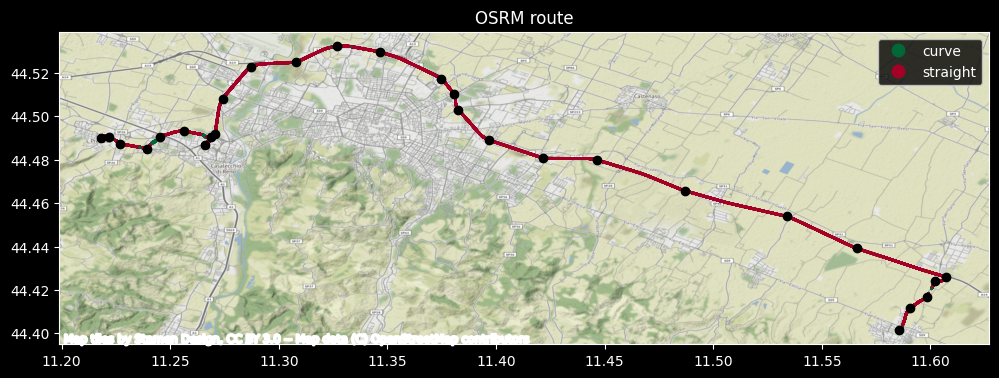

In [129]:
interp_dir.plot()

In [128]:
gdf = interp_dir.split_gdf
gdf0 = gdf.to_crs(CRS(proj='utm', zone=32, units="m", ellipsis="WGS84"))
gdf1 = gpd.GeoDataFrame({
    "geometry": gdf0.geometry,
    "iscurve": gdf0.iscurve.astype(bool),
    "num": [len(line.coords) for line in gdf0.geometry],
    "length": [line.length for line in gdf0.geometry],
})
print("Not curve")
display(gdf1[~gdf1.iscurve].describe())
print("Curve")
display(gdf1[gdf1.iscurve].describe())

Not curve


,num,length
count,64.000000,64.000000
mean,9.187500,630.010947
std,17.905284,2072.027839
min,2.000000,15.205314
25%,2.000000,39.319315
50%,4.000000,114.967976
75%,7.000000,329.659077
max,88.000000,15206.729967


Curve


,num,length
count,43.000000,43.000000
mean,4.930233,35.945494
std,6.045051,54.216491
min,2.000000,2.183433
25%,2.000000,12.263957
50%,3.000000,18.000306
75%,5.000000,36.304245
max,38.000000,329.437955


In [ ]:
meters_density = 5
pt_num = interp_dir.pt_num_for_density(meters_density)
print(f"For meters density {meters_density}m using {pt_num} points")

For meters density 5m using 2517 points


Testing with a roundabout tract (see [workflow_2.ipynb](./workflow_2.ipynb)).

In [ ]:
route_bounds = ((11.237, 44.484), (11.242, 44.488))

In [ ]:
# For testing, just crop the whole route instead of finding another shorter one
route2vel.utils.debug = True
gdf = interp_dir.get_points_with_num(pt_num, return_gdf=True, in_meters=True, gdf_columns=['base_idx', 'junction', 'speed_kph'])
proj_crs = gdf.crs
proj_crs

Projecting to UTM zone 32 (auto, from point [11.29253757 44.49647759])


<Projected CRS: +proj=utm +zone=32 +units=m +ellipsis +type=crs>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 32N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
calc_curvature(gdf)

In [ ]:
gdf.head()

,geometry,is_curve,split_gdf_index,base_idx,junction,speed_kph,curvature
0,POINT Z (686125.888 4929387.363 75.000),True,0,0,NaN,30.0,0.069010
1,POINT Z (686123.336 4929391.396 74.848),True,0,0,NaN,30.0,0.151663
2,POINT Z (686119.417 4929391.710 74.697),True,0,0,NaN,30.0,0.079122
3,POINT Z (686114.955 4929390.560 74.545),True,0,0,NaN,30.0,0.037149
4,POINT Z (686110.775 4929390.201 74.394),True,0,0,NaN,30.0,0.171462


In [ ]:
crop = clip_interp_gdf(gdf, route_bounds, Transformer.from_crs(direction.gdf.crs, proj_crs, always_xy=True).transform)
crop.describe()

,split_gdf_index,base_idx,speed_kph
count,0.0,0.0,0.0
mean,NaN,NaN,NaN
std,NaN,NaN,NaN
min,NaN,NaN,NaN
25%,NaN,NaN,NaN
50%,NaN,NaN,NaN
75%,NaN,NaN,NaN
max,NaN,NaN,NaN


In [ ]:
crop.head()

,geometry,is_curve,split_gdf_index,base_idx,junction,speed_kph,curvature


In [ ]:
print(f"Cropped points: {len(crop)}, {100 * len(crop) / len(gdf):.2f}%")

Cropped points: 0, 0.00%


gdf isn't included in bounds!


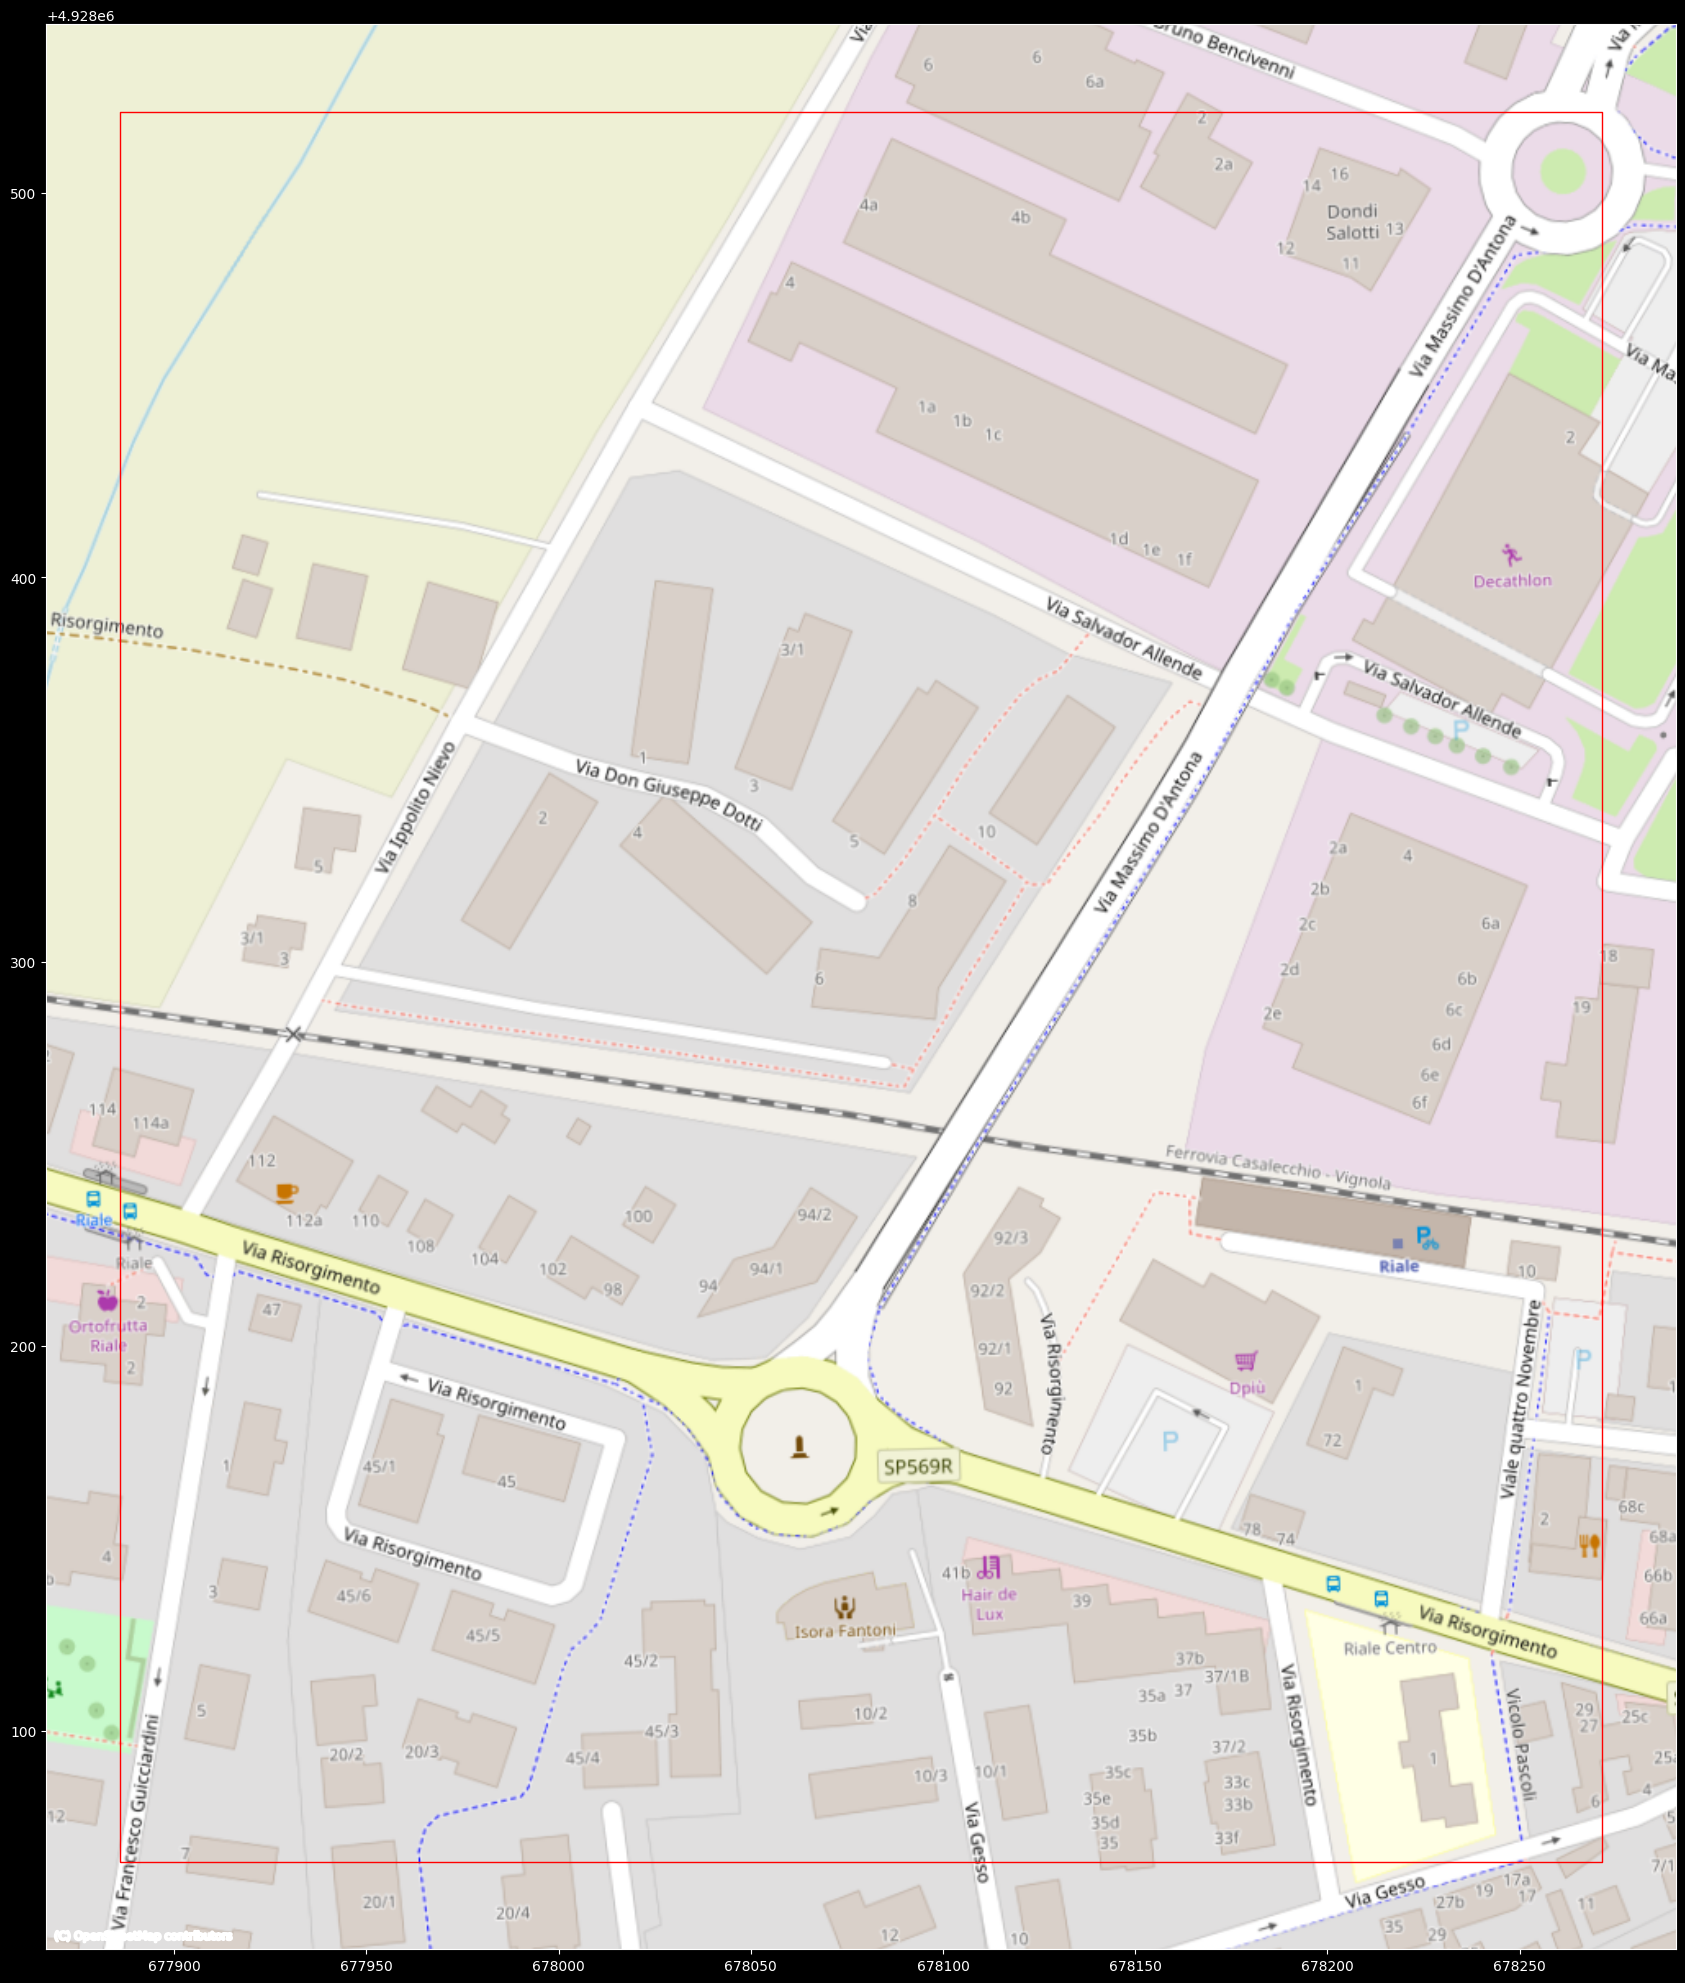

In [ ]:
tr = pyproj.Transformer.from_crs(direction.gdf.crs, gdf.crs, always_xy=True).transform
display_bounded_shapes([
    (gdf.reset_index(), {'column': 'is_curve', 'categorical':True, 'legend':True, 'cmap':'RdYlGn_r', 's': 10}, {
        "column": "index",
        "offset": (2, 4),
        "fontsize": 15
    }),
], tr(*route_bounds[0]), tr(*route_bounds[1]), crs=gdf.crs, figsize=(25,25));

In [20]:
crop_offset = offset_meters_gdf(crop)
crop_offset.head()

ValueError: min() arg is an empty sequence

In [ ]:
fname = "../../route_output.csv"
interp_gdf_to_csv(crop_offset, fname, separate_roundabout=True, add_tract_start_col=True, extra_cols=['speed_kph', 'curvature'])

Columns: ['lon', 'lat', 'ele', 'iscurve', 'start_line', 'speed_kph', 'curvature']
Written ../../route_output.csv


In [ ]:
fname = "../../route_output_full.csv"
interp_gdf_to_csv(offset_meters_gdf(gdf), fname, separate_roundabout=True, add_tract_start_col=True, extra_cols=['speed_kph', 'curvature'])

Columns: ['lon', 'lat', 'ele', 'iscurve', 'start_line', 'speed_kph', 'curvature']
Written ../../route_output_full.csv
